In [1]:
import sys
import os

sys.path.append('/home/davcic/CP_Testing')

# args = 5
# os.environ['CUDA_VISIBLE_DEVICES'] = f'{args}'
# print(f'Selected GPU {args}')
os.environ['CUDA_VISIBLE_DEVICES'] = ''


import matplotlib.pyplot as plt

import jax
import jax.random as jrnd
import jax.numpy as jnp
import jaxkern as jk

import matplotlib.colors as cm

from New_kernel_1 import Discontinuous_multiple
from New_kernel_1 import Discontinuous_multiple_params
from New_kernel_1 import Discontinuous_multiple_params_hyper
from Poisson_Process_added import Poisson_Process_hyper
from fullgp import FullMarginalGPModelhyper_mult
from Uniform_modified import Uniform_mod
from Normal_modified import LogNormal_mod
from fullgp import FullLatentGPModelhyper_mult

2024-05-24 12:21:25.408359: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


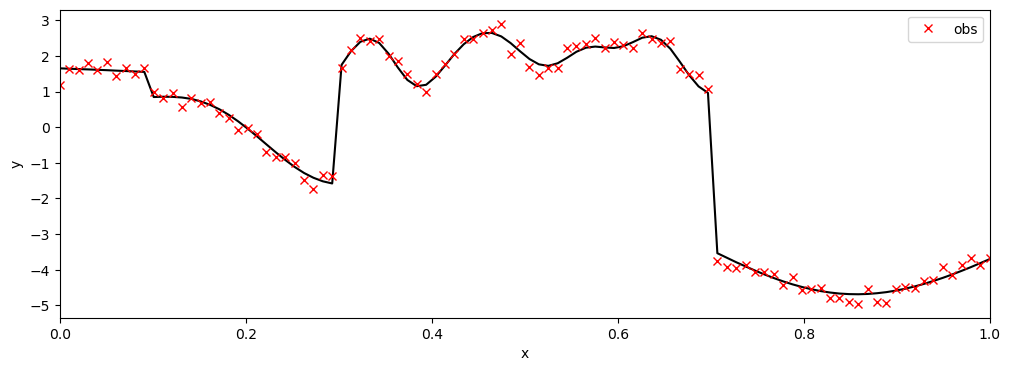

In [2]:
key = jrnd.PRNGKey(12345)

f_true = jnp.load("f_true.npy")
y = jnp.load("y.npy")

lengthscale_ = jnp.array([0.5, 0.1, 0.04, 0.2])
output_scale_ = jnp.array([3, 2, 1, 5])
obs_noise_ = 0.2
n = 100
x = jnp.linspace(0, 1, n)[:, jnp.newaxis]
x0 = jnp.array([0.3, 0.1, 0.7])
# x0 = jnp.concatenate((jnp.array([0]), x0, jnp.array([x.shape[0]])))
#x0 = jnp.append(jnp.zeros(1), x0, jnp.array(x.shape[0]))
base_kernel = jk.RBF()
kernel = Discontinuous_multiple_params(base_kernel, x0)
K = kernel.cross_covariance(params=dict(lengthscale=lengthscale_,
                                        variance=output_scale_,
                                        num=x0),
                            x=x, y=x)+ 1e-6*jnp.eye(n)

L = jnp.linalg.cholesky(K)
z = jrnd.normal(key, shape=(n,))

# f_true = jnp.dot(L, z) + jnp.ones_like(z)
# key, obs_key = jrnd.split(key)
# y = f_true + obs_noise_*jrnd.normal(obs_key, shape=(n,))

ground_truth = dict(f=f_true,
                    lengthscale=lengthscale_,
                    variance=output_scale_,
                    obs_noise=obs_noise_)

plt.figure(figsize=(12, 4))
plt.plot(x, f_true, 'k', label=r'')
plt.plot(x, y, 'rx', label='obs')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0., 1.])
plt.legend();

In [9]:
particles = jnp.load("test.npy", allow_pickle = True)[()]
particles[1]

{'f': Array([[ 1.45735705e+00,  1.40879261e+00,  1.35436475e+00,
          1.28971875e+00,  1.21430326e+00,  1.13438547e+00,
          1.04815042e+00,  9.57793593e-01,  8.63628030e-01,
          7.72961199e-01,  6.79230690e-01,  5.90429008e-01,
          5.02894878e-01,  4.20540750e-01,  3.45346272e-01,
          2.76436806e-01,  2.15088740e-01,  1.63200051e-01,
          1.19122282e-01,  8.68162736e-02,  6.31414726e-02,
          4.81317751e-02,  4.42975722e-02,  5.15156128e-02,
          6.30667359e-02,  8.36031735e-02,  1.12564787e-01,
          1.48218632e-01,  1.90738067e-01,  2.35725373e-01,
          2.84140706e-01,  3.37513506e-01,  3.94286513e-01,
          4.51690286e-01,  5.09351611e-01,  5.66024363e-01,
          6.21760964e-01,  6.80324674e-01,  7.37590551e-01,
          7.87924826e-01,  8.36983025e-01,  8.84894073e-01,
          9.28314388e-01,  9.68730986e-01,  1.00706124e+00,
          1.03793812e+00,  1.06360590e+00,  1.08491099e+00,
          1.09959543e+00,  1.105665

## 1 RUN

In [48]:
num_mcmc_steps = 1000
name = f"_{num_mcmc_steps}_scale1_1000000_var3_0_new_tempmax_0.8"
particles = jnp.load("particles" + name + ".npy", allow_pickle = True)[()]
f_pred = jnp.load("f_pred" + name + ".npy")
y_pred = jnp.load("y_pred" + name + ".npy")

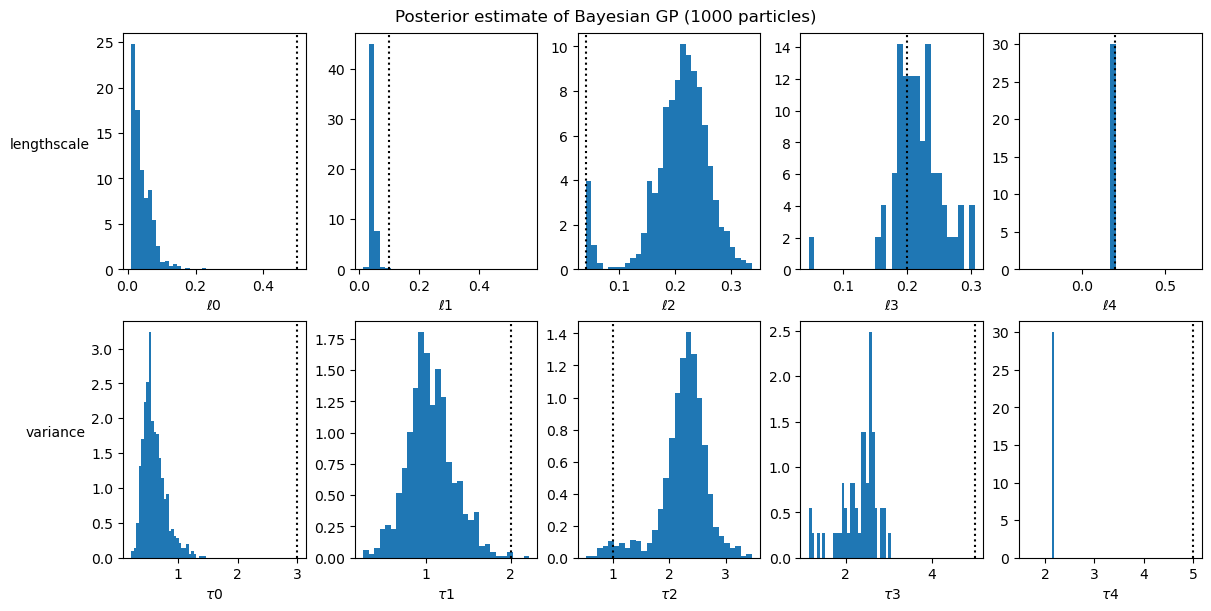

In [52]:
x_pred = jnp.linspace(-0, 1, num=100)

trainables = ['lengthscale', 'variance']

num_params = len(trainables)

symbols = dict(lengthscale='\ell',
            variance=r'\tau')
num_CP = 4
_, axes = plt.subplots(nrows=num_params, ncols=num_CP+1, constrained_layout=True,
                    figsize=(12, 6))


# particles = lgp_particles
tr = dict(lengthscale=particles['kernel']['lengthscale'],
            variance=particles['kernel']['variance'],
            )
for j, var in enumerate(trainables):
    pd = tr[var]
    # There are some outliers that skew the axes
    pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
    # pd_filtered = jnp.extract(pd>pd_l, pd)
    # pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)
    for i in range(num_CP+1):
      axes[j, i].hist(pd[:, i][~jnp.isnan(pd[:, i])], bins=30, density=True, color='tab:blue')
      axes[j, i].axvline(x=ground_truth[var][i], ls=':', c='k')

      if var in symbols:
          axes[j, i].set_xlabel(r'${:s}$'.format(symbols[var]+ str(i)))


num_particles = 1000
plt.suptitle(f'Posterior estimate of Bayesian GP ({num_particles} particles)');

axes[0, 0].set_ylabel('lengthscale', rotation=0, ha='right')
axes[1, 0].set_ylabel('variance', rotation=0, ha='right')

# plt.savefig("posterior" + name + ".png")

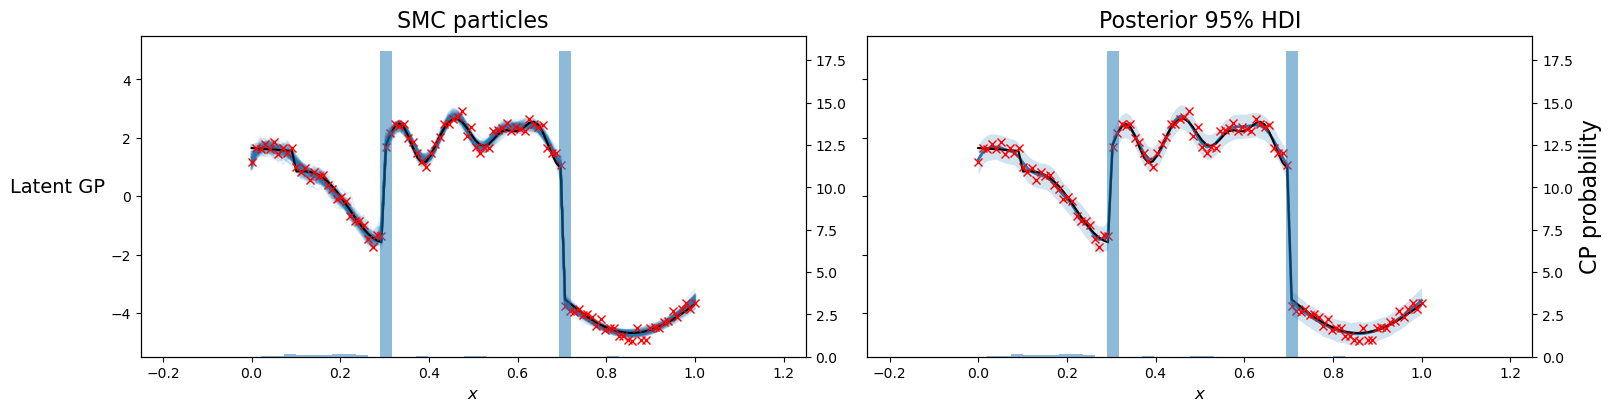

In [53]:
x_pred = jnp.linspace(0, 1, num=100)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4), sharex=True,
                            sharey=True, constrained_layout=True)


key, key_pred = jrnd.split(key)
# f_pred = gp_latent.predict_f(key_pred, x_pred)

pd = particles['kernel']['num']
# There are some outliers that skew the axis
# pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
# pd_filtered = jnp.extract(pd>pd_l, pd)
# pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)


ax = axes[0]
for i in jnp.arange(0, num_particles, step=10):
    ax.plot(x_pred, f_pred[i, :], alpha=0.1, color='tab:blue')

new_pd = pd[jnp.logical_not(jnp.isnan(pd))]
ax2 = ax.twinx()
ax2.hist(new_pd, bins=30, density=True, color='tab:blue', alpha=0.5)

ax = axes[1]
f_mean = jnp.nanmean(f_pred, axis=0)
# y_pred = gp_latent.predict_y(key_pred, x_pred)
f_hdi_lower = jnp.percentile(y_pred, q=2.5, axis=0)
f_hdi_upper = jnp.percentile(y_pred, q=97.5, axis=0)
# f_hdi_lower = jnp.percentile(f_pred, q=2.5, axis=0)
# f_hdi_upper = jnp.percentile(f_pred, q=97.5, axis=0)

ax.plot(x_pred, f_mean, color='tab:blue', lw=2)
ax.fill_between(x_pred, f_hdi_lower, f_hdi_upper,
                alpha=0.2, color='tab:blue', lw=0)

#print(new_pd.shape)

ax2 = ax.twinx()
ax2.hist(new_pd, bins=30, density=True, color='tab:blue', alpha=0.5)
ax2.set_ylabel('CP probability', fontsize=16)

for ax in axes.flatten():
    ax.plot(x, f_true, 'k', label=r'$f$')
    ax.plot(x, y, 'rx', label='obs')
    ax.set_xlim([-0.25, 1.25])
    ax.set_ylim([-5.5, 5.5])
    ax.set_xlabel(r'$x$', fontsize=12)

axes[0].set_title('SMC particles', fontsize=16)
axes[1].set_title('Posterior 95% HDI', fontsize=16)

axes[0].set_ylabel('Latent GP', rotation=0, ha='right', fontsize=14)

# plt.savefig("fit" + name + ".png")

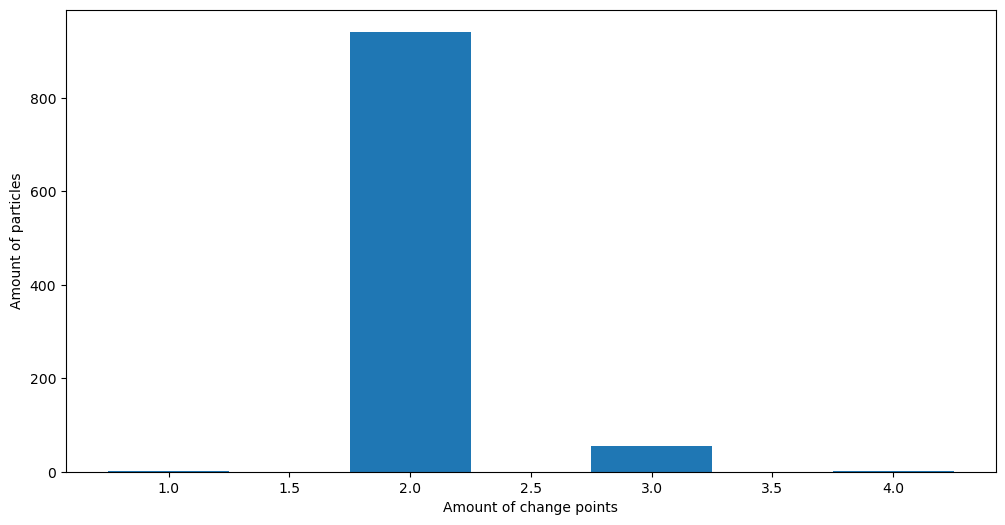

In [54]:
fig = plt.figure(figsize=(12, 6))
num_val = particles['kernel']['num']
counts = jnp.count_nonzero(~jnp.isnan(num_val), axis = 1)
uni_vals = jnp.sort(jnp.concatenate([jnp.unique(counts)-0.5, jnp.unique(counts)+0.5]))
plt.hist(counts, bins=uni_vals, rwidth = 0.5)
plt.xlabel("Amount of change points")
plt.ylabel("Amount of particles")

# plt.savefig("num" + name +".png")

## 10 RUNS

In [4]:
num_mcmc_steps = 1000
name = f"_{num_mcmc_steps}_scale1_1000000_var3_0_new_test"
particles = jnp.load("particles_all_10" + name + ".npy", allow_pickle = True)[()]
f_pred = jnp.load("f_pred_10" + name + ".npy")
y_pred = jnp.load("y_pred_10" + name + ".npy")

### Plotting

In [11]:
pd = particles
pd[0]['kernel']['num']

Array([[0.29674864, 0.3659169 , 0.51899457, ...,        nan,        nan,
               nan],
       [0.30022436, 0.39994317, 0.5069893 , ...,        nan,        nan,
               nan],
       [0.2969289 , 0.38444802, 0.50614035, ...,        nan,        nan,
               nan],
       ...,
       [0.2991517 , 0.40091836, 0.5227047 , ...,        nan,        nan,
               nan],
       [0.29729244, 0.40251753,        nan, ...,        nan,        nan,
               nan],
       [0.30043757, 0.39598945, 0.51243365, ...,        nan,        nan,
               nan]], dtype=float32)

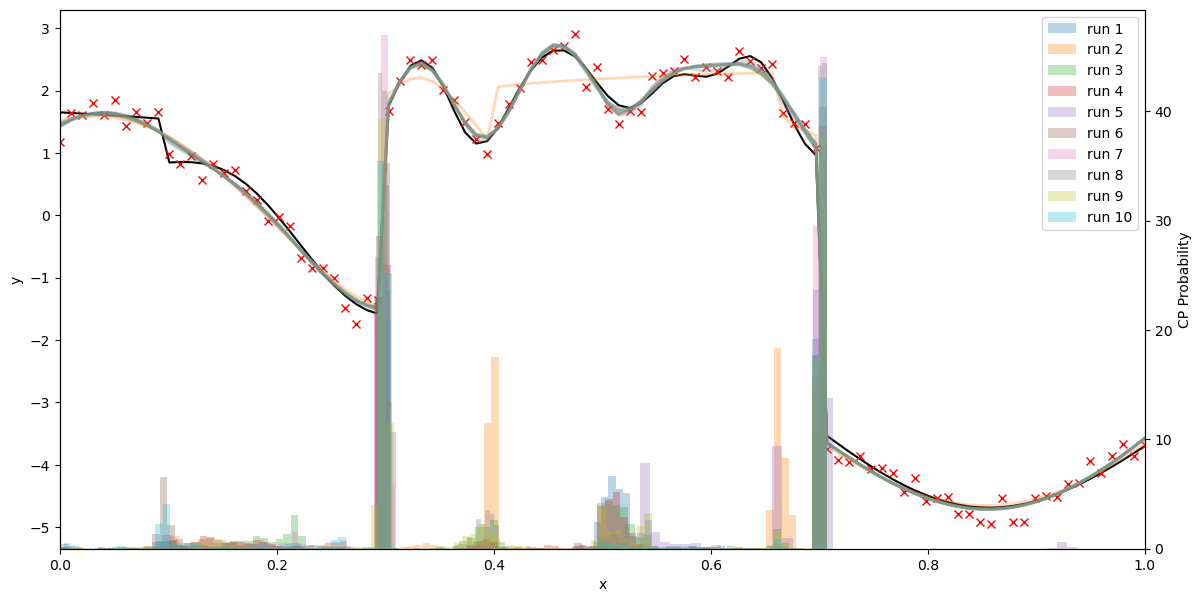

In [14]:
import matplotlib.colors as cm
# plt.style.use("Solarize_Light2")
plt.style.use("default")


key = jrnd.PRNGKey(12345)
num_runs = 10
max_CP = 20
# pd_all_new = jnp.reshape(particles, (num_particles, max_CP, num_runs))

f_true = jnp.load("f_true.npy")
y = jnp.load("y.npy")

lengthscale_ = jnp.array([0.5, 0.1, 0.04, 0.2])
output_scale_ = jnp.array([3, 2, 1, 5])
obs_noise_ = 0.2
n = 100
x = jnp.linspace(0, 1, n)[:, jnp.newaxis]
x0 = jnp.array([30, 10, 70])/n
# x0 = jnp.concatenate((jnp.array([0]), x0, jnp.array([x.shape[0]])))
#x0 = jnp.append(jnp.zeros(1), x0, jnp.array(x.shape[0]))
base_kernel = jk.RBF()
kernel = Discontinuous_multiple_params(base_kernel, x0)
K = kernel.cross_covariance(params=dict(lengthscale=lengthscale_,
                                        variance=output_scale_,
                                        num=x0),
                            x=x, y=x)+ 1e-6*jnp.eye(n)

L = jnp.linalg.cholesky(K)
z = jrnd.normal(key, shape=(n,))

# f_true = jnp.dot(L, z) + jnp.ones_like(z)
# key, obs_key = jrnd.split(key)
# y = f_true + obs_noise_*jrnd.normal(obs_key, shape=(n,))

ground_truth = dict(f=f_true,
                    lengthscale=lengthscale_,
                    variance=output_scale_,
                    obs_noise=obs_noise_)

fig, ax1 = plt.subplots(figsize=(14, 7))
ax1.plot(x, f_true, 'k', label=r'')
ax1.plot(x, y, 'rx', label='obs')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_xlim([0., 1.])
# ax1.legend();

# x_pred = jnp.linspace(-0.25, 1.25, num=150)
# f_pred = gp_marginal.predict_f(key_pred, x_pred)

#ax2 = ax1.twinx()
#ax2.hist(pd_all.T, bins=30, density=True, histtype='bar', stacked=True, alpha = 0.5)
#ax2.set_ylabel('CP Probability')
#plt.show()
colors = [cm.to_hex(plt.cm.tab10(i)) for i in range(num_runs)]

x_pred = jnp.linspace(0, 1, num=100)

ax2 = ax1.twinx()
for i, c in zip(range(num_runs), colors):
  #print(i)
  f_mean = jnp.mean(f_pred[:, :, i], axis=0)
  # f_hdi_lower = jnp.percentile(f_pred[:, :, i], q=2.5, axis=0)
  # f_hdi_upper = jnp.percentile(f_pred[:, :, i], q=97.5, axis=0)

  ax1.plot(x_pred, f_mean, color=c, lw=2, alpha = 0.3)
  # ax1.fill_between(x_pred, f_hdi_lower, f_hdi_upper,
  #                 alpha=0.2, color=c, lw=0)
  # ax2.hist(particles[:, i].T, bins=100, density=True, alpha = 0.3, color = c, label = f'run {i+1}')
  # new_num_all = jnp.reshape(num_all, (num_all.shape[0]* num_all.shape[1], num_all.shape[2]))
  # ax2.hist(new_num_all[:, i].T, bins=100, density=True, alpha = 0.3, color = c, label = f'run {i+1}')
  ax2.hist(pd[i]['kernel']['num'].flatten(), bins=100, density=True, alpha = 0.3, color = c, label = f'run {i+1}')

ax2.set_ylabel('CP Probability')
ax2.legend()

# plt.savefig("fit" + name + ".png")

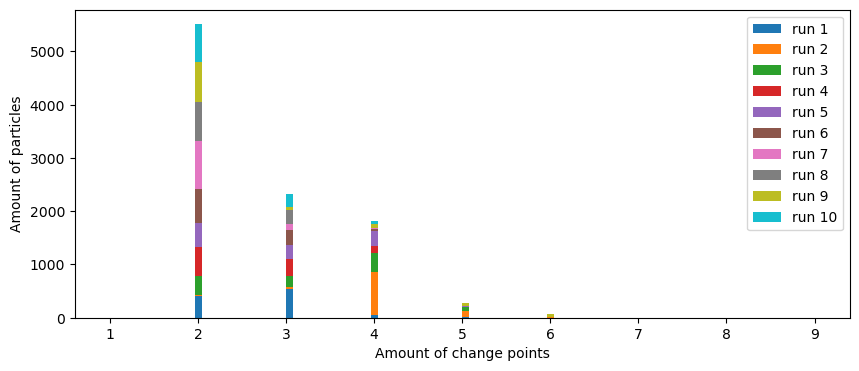

In [17]:
fig = plt.figure(figsize=(10,4))

key, key_pred = jrnd.split(key)
num_particles = 1000
# pd_all_new = jnp.reshape(particles, (num_particles, max_CP, num_runs))
# pd_all_new = num_all

counts = jnp.zeros((num_particles, num_runs))
for i, c in zip(range(num_runs), colors):
  # counts = counts.at[:, i].set(jnp.count_nonzero(~jnp.isnan(pd_all_new[:, :, i]), axis = 1))
  counts = counts.at[:, i].set(jnp.count_nonzero(~jnp.isnan(pd[i]['kernel']['num']), axis = 1))
  uni_vals = jnp.sort(jnp.concatenate([jnp.unique(counts)-0.5, jnp.unique(counts)+0.5]))

labels = ["run 1", "run 2", "run 3", "run 4", "run 5", "run 6", "run 7", "run 8", "run 9", "run 10"]

plt.hist(counts.T, bins=100, histtype = 'bar', stacked=True, color = colors, label = labels)
plt.xlabel("Amount of change points")
plt.ylabel("Amount of particles")
plt.legend()

# plt.savefig("num" + name+ ".png")

### Testing covergence

I need my own function becasue my sampels contains Nans

In [8]:
import jax
import jax.numpy as jnp
import numpy as np
from scipy.fftpack import next_fast_len  # type: ignore

# from blackjax.types import Array, ArrayLike

def potential_scale_reduction(
    input_array, chain_axis: int = 0, sample_axis: int = 1
):
    """Gelman and Rubin (1992)'s potential scale reduction for computing multiple MCMC chain convergence.

    Parameters
    ----------
    input_array:
        An array representing multiple chains of MCMC samples. The array must
        contains a chain dimension and a sample dimension.
    chain_axis
        The axis indicating the multiple chains. Default to 0.
    sample_axis
        The axis indicating a single chain of MCMC samples. Default to 1.

    Returns
    -------
    NDArray of the resulting statistics (r-hat), with the chain and sample dimensions squeezed.

    Notes
    -----
    The diagnostic is computed by:

    .. math:: \\hat{R} = \\frac{\\hat{V}}{W}

    where :math:`W` is the within-chain variance and :math:`\\hat{V}` is the posterior variance
    estimate for the pooled traces. This is the potential scale reduction factor, which
    converges to unity when each of the traces is a sample from the target posterior. Values
    greater than one indicate that one or more chains have not yet converged :cite:p:`stan_rhat,gelman1992inference`.

    """
    assert (
        input_array.shape[chain_axis] > 1
    ), "potential_scale_reduction as implemented only works for two or more chains."

    num_samples = input_array.shape[sample_axis]
    # Compute stats for each chain
    per_chain_mean = jnp.nanmean(input_array, axis=sample_axis, keepdims=True)
    per_chain_var = jnp.nanvar(input_array, axis=sample_axis, ddof=1, keepdims=True)
    # Compute between-chain stats
    between_chain_variance = num_samples * per_chain_mean.var(
        axis=chain_axis, ddof=1, keepdims=True
    )
    # Compute within-chain stats
    within_chain_variance = per_chain_var.mean(axis=chain_axis, keepdims=True)
    # Estimate of marginal posterior variance
    rhat_value = jnp.sqrt(
        (between_chain_variance / within_chain_variance + num_samples - 1)
        / (num_samples)
    )
    return rhat_value.squeeze()

In [43]:
particles[0]['kernel']['lengthscale']

Array([[0.04244832, 0.2016612 ,        nan, ...,        nan,        nan,
               nan],
       [0.04449949, 0.21940582,        nan, ...,        nan,        nan,
               nan],
       [0.04618543, 0.18373363,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.01635459, 0.05566701, 0.24138631, ...,        nan,        nan,
               nan],
       [0.01681704, 0.04574801, 0.24876174, ...,        nan,        nan,
               nan],
       [0.01653212, 0.05204884, 0.1938994 , ...,        nan,        nan,
               nan]], dtype=float32)

In [46]:
new_particles = jnp.reshape(particles, (1000, 20, 10))
# new_particles[0, :, 1]
convergence =  potential_scale_reduction(new_particles, 2, 0)
convergence

Array([1.0437454, 1.0239917, 1.028534 , 1.038422 , 1.2416087, 1.7885542,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan], dtype=float32)

In [16]:
f_all = jnp.zeros((1000, 100, 10))
num_all = jnp.zeros((1000, 20, 10))
len_all = jnp.zeros((1000, 21, 10))
var_all = jnp.zeros((1000, 21, 10))
obs_all = jnp.zeros((1000, 10))
hyper_all = jnp.zeros((1000, 10))
for i, part in enumerate(particles):
    for key, value in part.items():
        if key == 'f':
            f_all = f_all.at[:, :, i].set(value)
        if key == 'kernel':
            for key2, value2 in value.items():
                if key2 == 'num':
                    num_all = num_all.at[:, :, i].set(value2)
                if key2 == 'lengthscale':
                    len_all = len_all.at[:, :, i].set(value2)
                if key2 == 'variance':
                    var_all = var_all.at[:, :, i].set(value2)
        if key == 'hyper':
            hyper_all = hyper_all.at[:, i].set(value['hyper_pp'])
        if key == 'likelihood':
            obs_all = obs_all.at[:, i].set(value['obs_noise'])

    # print(value.shape)
    # convergence =  potential_scale_reduction(value, 2, 0)
    # print(convergence)

In [35]:
particles[0]['kernel']['num']

Array([[0.6969785 ,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.699046  ,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.7057849 ,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan, 0.2967117 , 0.7020719 , ...,        nan,        nan,
               nan],
       [       nan, 0.30055374, 0.7056653 , ...,        nan,        nan,
               nan],
       [       nan, 0.3009118 , 0.70513844, ...,        nan,        nan,
               nan]], dtype=float32)

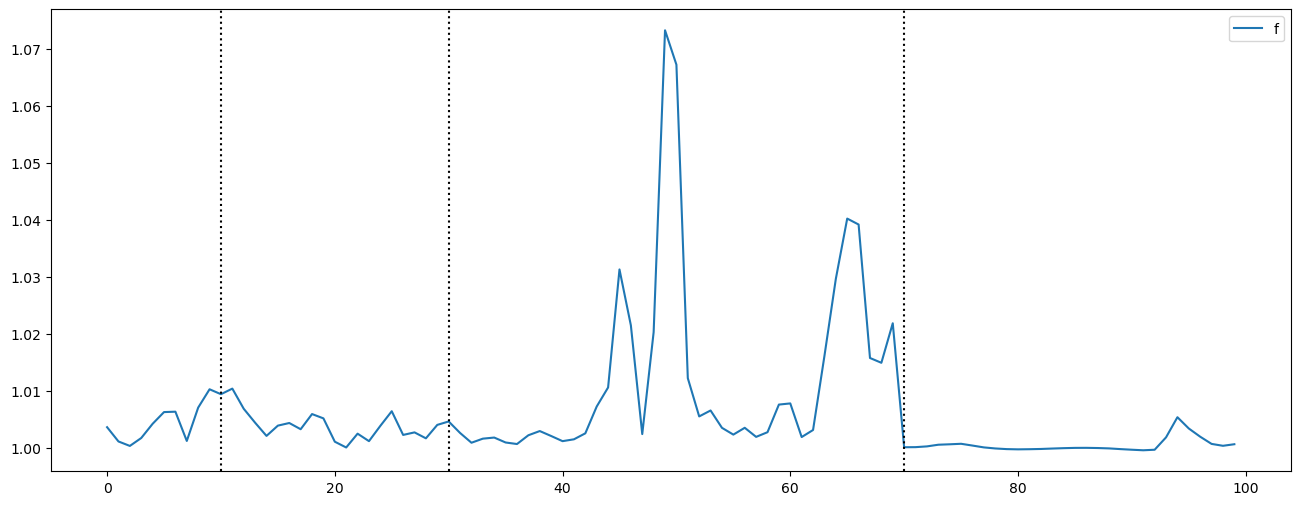

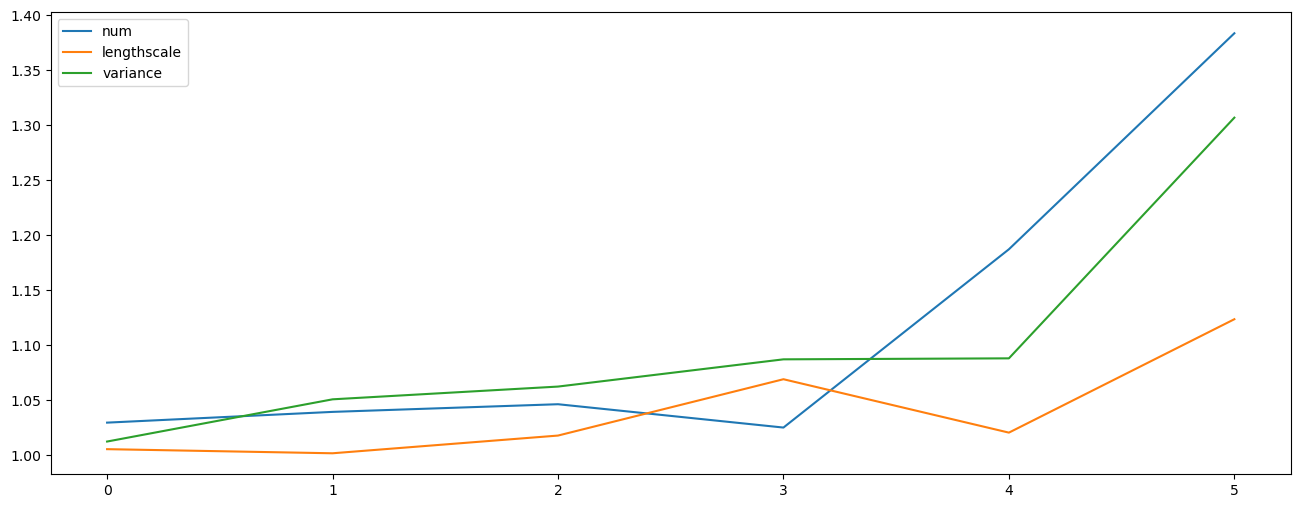

In [29]:
convergence_f =  potential_scale_reduction(f_all, 2, 0)
convergence_num =  potential_scale_reduction(num_all, 2, 0)
convergence_len =  potential_scale_reduction(len_all, 2, 0)
convergence_var =  potential_scale_reduction(var_all, 2, 0)
convergence_obs =  potential_scale_reduction(obs_all, 1, 0)
convergence_hyper =  potential_scale_reduction(hyper_all, 1, 0)

fig = plt.figure(figsize = (16, 6))
plt.plot(convergence_f, label = 'f')
# plt.plot(convergence_obs, label = 'obs_noise')
# plt.plot(convergence_hyper, label = 'hyper')
[plt.axvline(x=_x*100, ls=':', c='k')for _x in x0]
plt.legend()
plt.show()

fig = plt.figure(figsize = (16, 6))
plt.plot(convergence_num, label = 'num')
plt.plot(convergence_len, label = 'lengthscale')
plt.plot(convergence_var, label = 'variance')
plt.legend()
plt.show()

In [30]:
print(convergence_obs)
print(convergence_hyper)

1.0087775
1.9462907


In [31]:
print(convergence_num)
print(convergence_len)

[1.0294484 1.0392274 1.0462013 1.024965  1.1872098 1.383766        nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan]
[1.0053073 1.0015609 1.0176766 1.0689496 1.0203538 1.1235574       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan]


In [32]:
print(num_all)

[[[0.6969785  0.70091456 0.30284435 ... 0.3010765  0.10008784        nan]
  [       nan        nan 0.39549512 ...        nan        nan 0.29944938]
  [       nan        nan 0.70186174 ... 0.702228   0.29799727 0.7059878 ]
  ...
  [       nan        nan        nan ...        nan        nan        nan]
  [       nan        nan        nan ...        nan        nan        nan]
  [       nan        nan        nan ...        nan        nan        nan]]

 [[0.699046   0.69980174 0.2950002  ... 0.29908913        nan        nan]
  [       nan        nan 0.39772633 ...        nan 0.15742855 0.30083483]
  [       nan        nan        nan ... 0.7025385  0.30109766 0.70186937]
  ...
  [       nan        nan        nan ...        nan        nan        nan]
  [       nan        nan        nan ...        nan        nan        nan]
  [       nan        nan        nan ...        nan        nan        nan]]

 [[0.7057849         nan 0.2932706  ...        nan        nan        nan]
  [       nan 0.237071